In [1]:
import re
from pathlib import Path
import string
from functools import reduce
from math import log
import itertools

In [2]:
# Enter smoothing or no smoothing.
smoothing = 1
filename = "textfile.txt"

TASK 1 (A): Pre-Processing of RAW Text File: Split File to Sentences

In [3]:
# Loads file
# input - filename.txt
# returns a list of sentences seperated by newline in the textfile.
def load_file(filename):
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines

TASK 1 (B): Perform Tokenization Technique on Raw Text File

In [4]:
# Tokenizes the sentences meaning split the sentences into words seperated by the "white sapce".
# input - List of sentences
# returns a list of lists of each sentence being tokenized.
def tokenize_sentence(lines):
    lines = [line.split() for line in lines]
    return lines

In [6]:
dataset = load_file(filename)
dataset = tokenize_sentence(dataset)
dataset = prep_data(dataset)

No of sentences in Corpus: 10059


TASK 1 (B): Perform Removing of StopWords and Empty Strings, Stemming, Lemmatization and Appending Technique on Raw Text File

In [5]:
import string
# remove punctuations -print(string.punctuation) ---- !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ----
# remove empty strings.
# lower case all the words
# add <s> at the beginning and </s> at the end of every sentence in the corpus.
# input - list of lists of words obtained from "tokenize_sentence" function.
# returns - list of lists
def prep_data(lines):
    ### Write your Code here
        # remove punctuations
    punctuations = string.punctuation
    lines = [[word for word in sentence if word not in punctuations] for sentence in lines]
        # removes empty strings
    lines = [[word for word in sentence if word] for sentence in lines]
        # lower case
    lines = [[word.lower() for word in sentence] for sentence in lines]
        # Append </s> at the end of each sentence in the corpus
    lines = [['<s>'] + sentence + ['</s>'] for sentence in lines]
        # Append <s> at the beginning of each sentence in the corpus
    print("No of sentences in Corpus: "+str(len(lines)))
    return lines

In [7]:
# Counts the no. of times a word repeats (frequency of each word) in the corpus.
# input - list of lists of words obtained from "prep_data"
# returns - a dictionary defined as {word:frequency} for words of the corpus including <s> and </s>.
def freq_of_unique_words(lines):
    ### Write your Code here
    words_list = [word for sentence in lines for word in sentence] # make a 1d array
    count = {}
    for word in words_list:
        if word in count:
            count[word] += 1
        else:
            count[word] = 1

    unique_word_count = len(count)
    print("No of unique words in corpus : "+ str(unique_word_count))
    print("No of words in corpus: " + str(sum(count.values())))
    return count

In [8]:
unique_word_frequency = freq_of_unique_words(dataset)
#len(unique_word_frequency)

No of unique words in corpus : 17210
No of words in corpus: 241876


TASK2: Implementation of Naive Baye's Classifier from Scratch

In [16]:
import numpy as np

class NaiveBayes:
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def __init__(self):
        self.prior = {}
        self.mean = {}
        self.variance = {}
        self.smoothing = 1e-7 # to avoid division by zero

    def calc_prior(self, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        ### Write your code here

        unique_classes, counts = np.unique(target, return_counts=True)
        total_samples = len(target)
        self.prior = {class_: count / total_samples for class_, count in zip(unique_classes, counts)}
        return self.prior

    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        '''
        ### Write your code here

        unique_classes = np.unique(target)
        for class_ in unique_classes:
            features_cls = features[target == class_]
            self.mean[class_] = np.mean(features_cls, axis=0)
            self.variance[class_] = np.var(features_cls, axis=0) + self.smoothing
        return self.mean, self.variance

    def gaussian_density(self, x, mean, var):
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed

        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        ### Write your code here
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent

    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        ### Write your code here
        # return class with highest posterior probability
        for class_ in self.prior:
            prior = self.prior[class_]
            conditional = np.prod([self.gaussian_density(x[i], self.mean[class_][i], self.variance[class_][i]) for i in range(len(x))])
            posterior = prior * conditional
            posteriors.append(posterior)
        return np.argmax(posteriors)

    def fit(self, features, target):
        '''
        Train the model by calculating prior, mean, and variance
        '''
        self.calc_prior(target)
        self.calc_statistics(features, target)

    def predict(self, features):
        ### Write your code here
        ### preds for posterior prob
        preds = [self.calc_posterior(x) for x in features]
        return preds

    def accuracy(self, y_test, y_pred):
        ### Write your code here
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy


TASK: Train the Model on Given Classification Dataset by splitting it into ratio of 80:20 and calculate the accuracy of the trained classifier.

In [13]:
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

### Write Your Code Here

dataset = load_file('textfile.txt')
tokenized_data = tokenize_sentence(dataset)
processed_data = prep_data(tokenized_data)


# join sentences for count vectorizer
sentences = [' '.join(sentence) for sentence in processed_data]
# generate random labels (0 or 1)
labels = np.random.randint(2, size=len(sentences))

vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(sentences).toarray()
features = vectorizer.get_feature_names_out()

le = LabelEncoder()
y = le.fit_transform(labels)

split_ratio = 0.8
split_index = int(len(sentences) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

No of sentences in Corpus: 10059


TASK 3: Implement Naive Bayes Classifier Using Built-In function
Calculate the Accuracy Score and Metrics for Given Dataset and Compare the Results with your designed algorithm.
Compare using classification matrix and Plots for accuracy, precision and Recall

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.51      0.67      0.58      1023
     Class 1       0.49      0.33      0.40       989

    accuracy                           0.50      2012
   macro avg       0.50      0.50      0.49      2012
weighted avg       0.50      0.50      0.49      2012

Confusion Matrix:
[[687 336]
 [661 328]]
Scratch 

Accuracy: 0.51

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.51      0.96      0.66      1023
     Class 1       0.49      0.04      0.07       989

    accuracy                           0.51      2012
   macro avg       0.50      0.50      0.37      2012
weighted avg       0.50      0.51      0.37      2012

Confusion Matrix:
[[982  41]
 [950  39]]


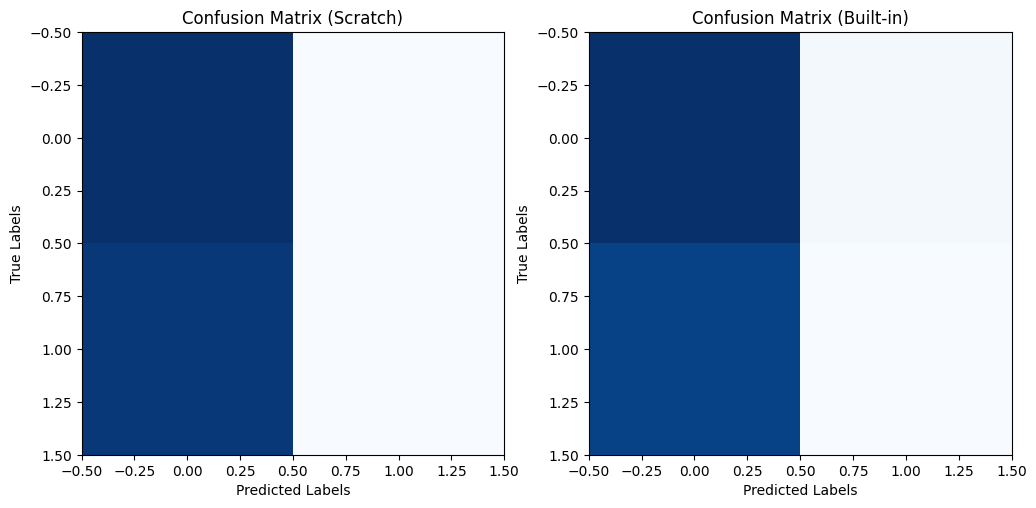

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# builtin
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# scratch
nb_scratch = NaiveBayes()
nb_scratch.fit(X_train, y_train)
y_pred_scratch = nb_scratch.predict(X_test)
acc_scratch = nb_scratch.accuracy(y_test, y_pred_scratch)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.2f}\n")
print("Classification Report:")
print(report)

print("Confusion Matrix:")
print(conf_matrix)

accuracy_sc = nb_scratch.accuracy(y_test, y_pred_scratch)
report_sc = classification_report(y_test, y_pred_scratch, target_names=['Class 0', 'Class 1'])
conf_matrix_sc = confusion_matrix(y_test, y_pred_scratch)

print("Scratch \n")
print(f"Accuracy: {accuracy_sc:.2f}\n")
print("Classification Report:")
print(report_sc)

print("Confusion Matrix:")
print(conf_matrix_sc)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(conf_matrix_sc, cmap='Blues', interpolation='nearest')
axs[0].set_title('Confusion Matrix (Scratch)')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

axs[1].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
axs[1].set_title('Confusion Matrix (Built-in)')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.show()